<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clustering-from-k-means-to-HDBSCAN" data-toc-modified-id="Clustering-from-k-means-to-HDBSCAN-1">Clustering from k-means to HDBSCAN</a></span></li><li><span><a href="#World-cities" data-toc-modified-id="World-cities-2">World cities</a></span></li><li><span><a href="#Classification-of-clustering-algorithms*" data-toc-modified-id="Classification-of-clustering-algorithms*-3">Classification of clustering algorithms<sup>*</sup></a></span></li><li><span><a href="#k-means" data-toc-modified-id="k-means-4">k-means</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-5">Hierarchical clustering</a></span></li><li><span><a href="#HDBSCAN" data-toc-modified-id="HDBSCAN-6">HDBSCAN</a></span></li></ul></div>

https://www.youtube.com/watch?v=dGsxd67IFiU&ab_channel=PyData

# Clustering from k-means to HDBSCAN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *
plt.rcParams['figure.figsize'] = [12.0, 8.0]

# World cities

In [2]:
# https://simplemaps.com/data/world-cities
cities = pd.read_csv('worldcities.csv')
cities = cities[['city', 'lat', 'lng', 'country', 'iso2', 'population']]
cities = cities.dropna()
cities = cities.query('population > 1e3')

# https://datahub.io/JohnSnowLabs/country-and-continent-codes-list
continents = pd.read_csv('https://datahub.io/JohnSnowLabs/country-and-continent-codes-list/r/0.csv')
continents = continents[['Continent_Name', 'Two_Letter_Country_Code']].rename(
    {'Continent_Name':'continent', 'Two_Letter_Country_Code':'iso2'},
    axis=1
)
world = cities.merge(continents)
world

,city,lat,lng,country,iso2,population,continent
0,Tokyo,35.6897,139.6922,Japan,JP,37977000.0,Asia
1,Ōsaka,34.6936,135.5019,Japan,JP,14977000.0,Asia
2,Nagoya,35.1167,136.9333,Japan,JP,9113000.0,Asia
3,Yokohama,35.4333,139.6333,Japan,JP,3748781.0,Asia
4,Fukuoka,33.5903,130.4019,Japan,JP,2128000.0,Asia
...,...,...,...,...,...,...,...
26829,Koror,7.3433,134.4804,Palau,PW,8744.0,Oceania
26830,Melekeok,7.4874,134.6265,Palau,PW,7026.0,Oceania
26831,Grand Turk,21.4664,-71.1360,Turks And Caicos Islands,TC,5801.0,North America
26832,Avarua,-21.2070,-159.7710,Cook Islands,CK,5445.0,Oceania


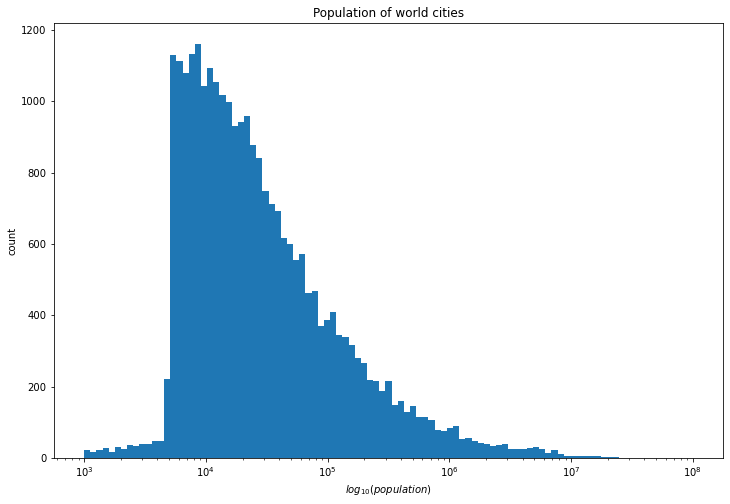

In [3]:
plt.hist(world['population'], bins=np.logspace(3,8, 100))
plt.xscale('log')
plt.xlabel('$log_{10}(population)$')
plt.ylabel('count')
plt.title('Population of world cities');

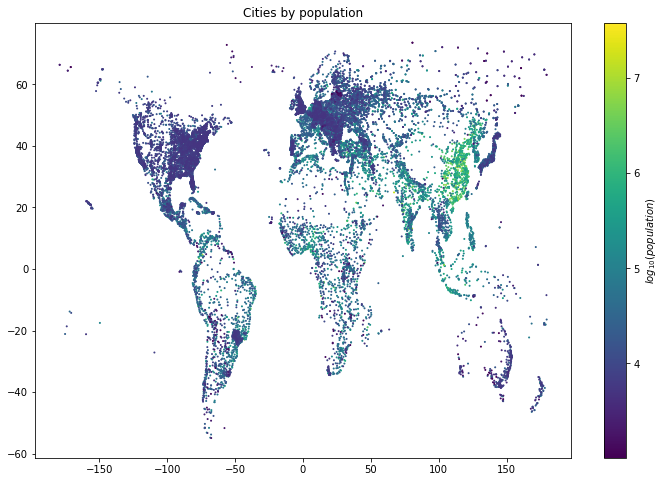

In [4]:
plt.scatter(world['lng'], world['lat'], c=np.log10(world['population']), s=1)
cbar = plt.colorbar()
cbar.set_label('$log_{10}(population)$')
plt.title('Cities by population');

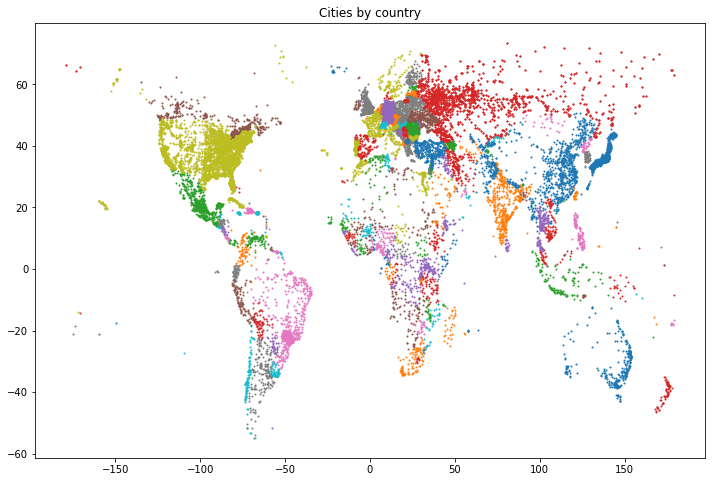

In [5]:
for country, df in world.groupby('country'):
    plt.scatter(df['lng'], df['lat'], s=1)
plt.title('Cities by country');

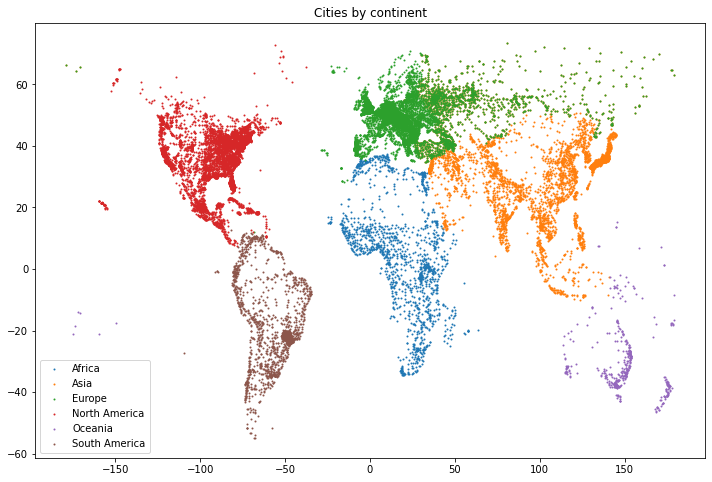

In [6]:
# There is a problem that cities in Russia and Turkey were assigned both to Europe and Asia
for continent, df in world.groupby('continent'):
    plt.scatter(df['lng'], df['lat'], s=1, label=continent)
plt.legend()
plt.title('Cities by continent');

# Classification of clustering algorithms<sup>*</sup>

<table>
    <tr>
        <td>
        <th>Flat
        <th>Hierarchical
    </tr>
    <tr>
        <th>Centroid / Parametric
        <td>k-means
        <td>Agglomerative
    </tr>
    <tr>
        <th>Density / Non-parametric
        <td>DBSCAN
        <td>HDBSCAN
    </tr>
</table>
            
\* https://www.youtube.com/watch?v=dGsxd67IFiU&ab_channel=PyData

# k-means

In [7]:
asia = world.query('continent == "Asia" and lng > 0')
big10 = (asia.groupby('country')['city'].count().sort_values(ascending=False)
         .iloc[:10].index.values)
asia = asia[asia['country'].isin(big10)]
X = asia[['lng', 'lat']].values
labels = asia['country'].values

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [11]:
centers = kmeans.cluster_centers_

(10.0, 160.0)

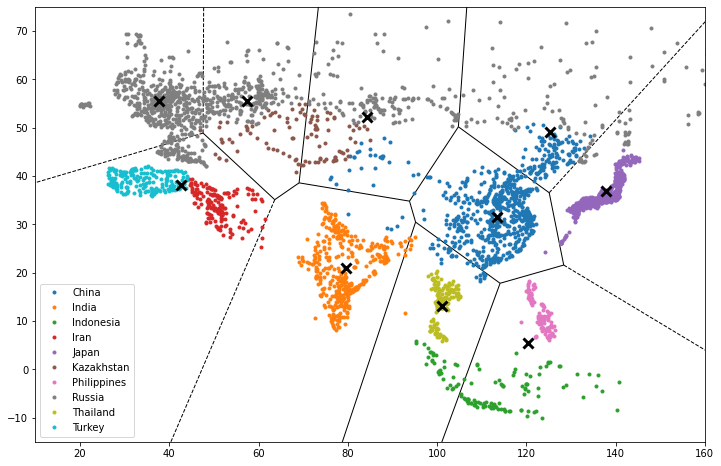

In [12]:
fig, ax = plt.subplots()

for country in np.unique(labels):
    X_c = X[labels == country]
    ax.plot(X_c[:,0], X_c[:,1], '.', label=country)
ax.legend();

from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(centers)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False);
# plt.scatter(centers[:,0], centers[:,1], marker='x', s=150, c='black')
plt.plot(centers[:,0], centers[:,1], 'x', c='black', markersize=10, markeredgewidth=3)
plt.ylim(-15, 75)
plt.xlim(10, 160)

# Hierarchical clustering

In [13]:
import scipy.cluster.hierarchy as sch

def dendrogram(Z, k):
    max_d = Z[-k+1, 2]
    dend = sch.dendrogram(Z, labels=labels, leaf_font_size=10, color_threshold=max_d)
    plt.gca().yaxis.set_visible(False)
    plt.axhline(max_d, c='silver')

In [14]:
europe = world.query('continent == "Europe" and 50 > lng > -50')
emetro = europe.query('population > 1e6 and country != "Turkey"')

X = emetro[['lng', 'lat']].values
labels = emetro['city'].values

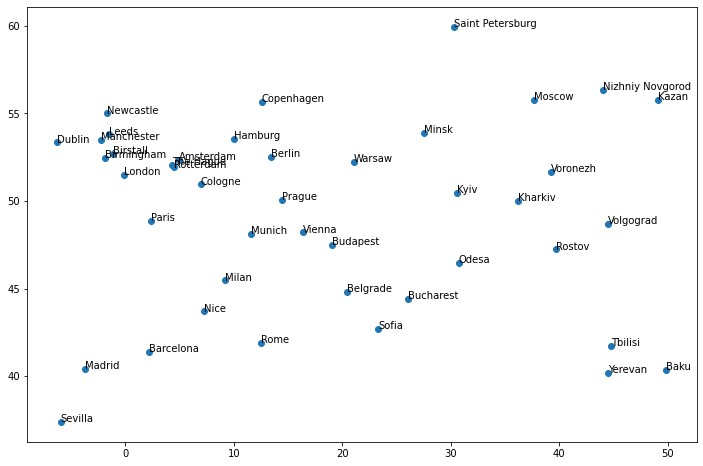

In [15]:
plt.scatter(X[:,0], X[:,1])
for xy, city in zip(X, labels):
    plt.annotate(city, xy)

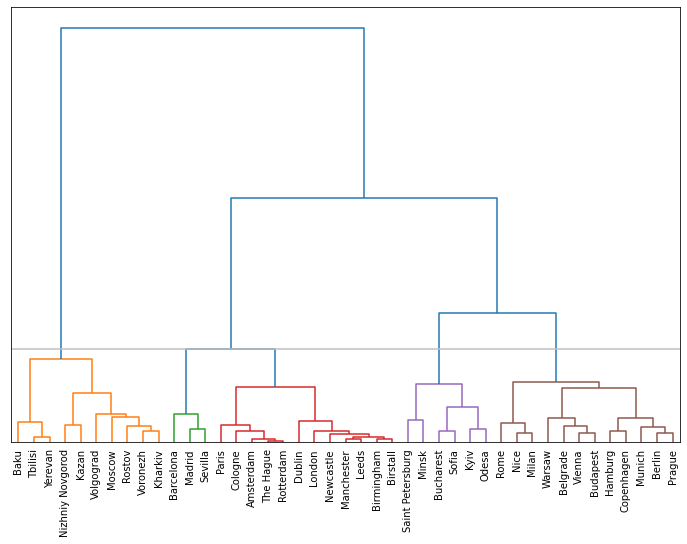

In [16]:
Z = sch.linkage(X, method='ward')
dendrogram(Z, 5)

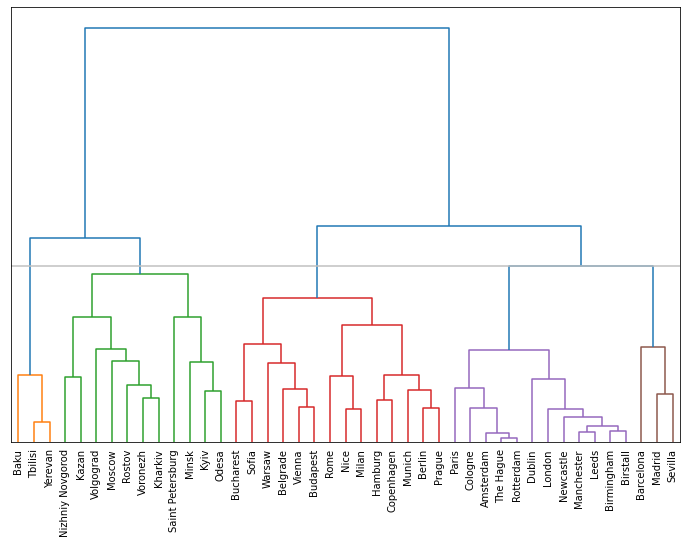

In [17]:
Z = sch.linkage(X, method='average')
dendrogram(Z, 5)

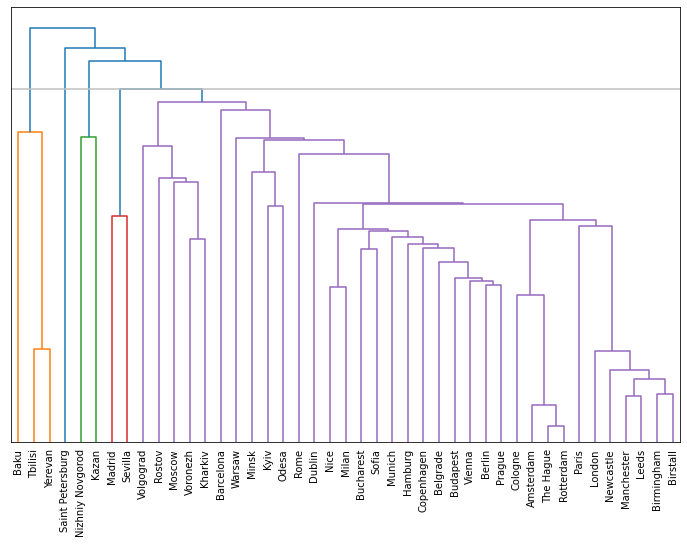

In [18]:
Z = sch.linkage(X, method='single')
dendrogram(Z, 5)

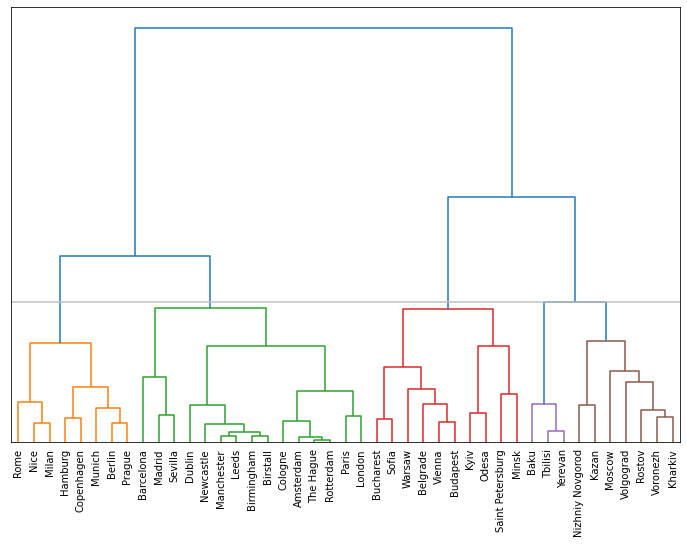

In [19]:
Z = sch.linkage(X, method='complete')
dendrogram(Z, 5)

# HDBSCAN

In [20]:
X = asia[['lng', 'lat']].values
labels = asia['country'].values

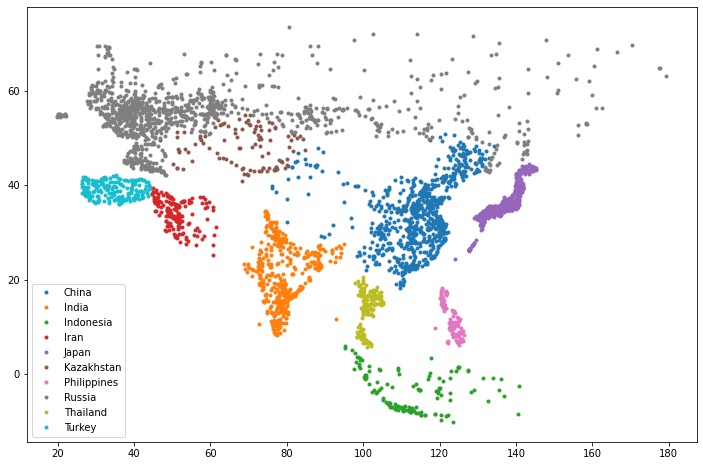

In [21]:
fig, ax = plt.subplots()
for country in np.unique(labels):
    X_c = X[labels == country]
    ax.plot(X_c[:,0], X_c[:,1], '.', label=country)
ax.legend();

In [22]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True)
clusterer.fit(X);

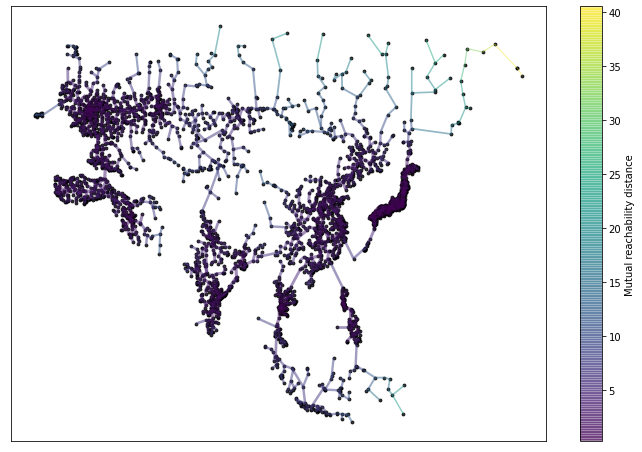

In [23]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', node_size=8, edge_linewidth=.9);

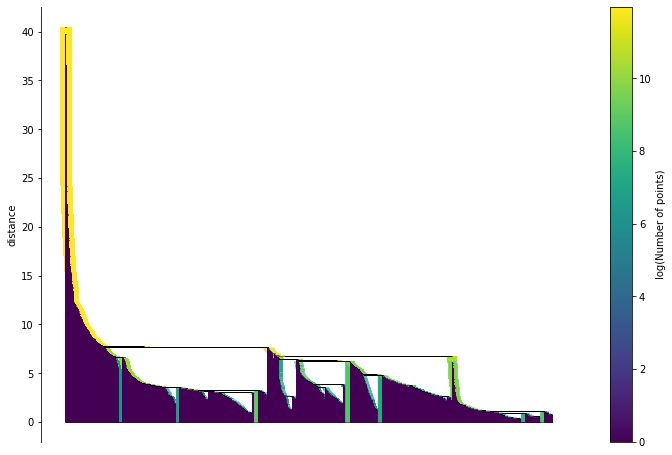

In [24]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True);

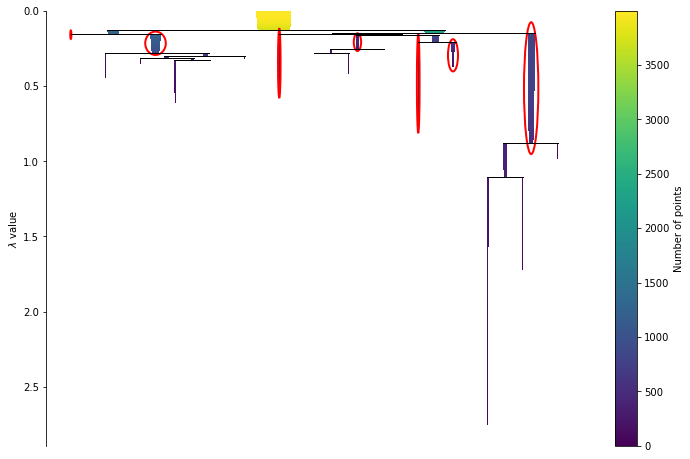

In [25]:
clusterer.condensed_tree_.plot(select_clusters=True);

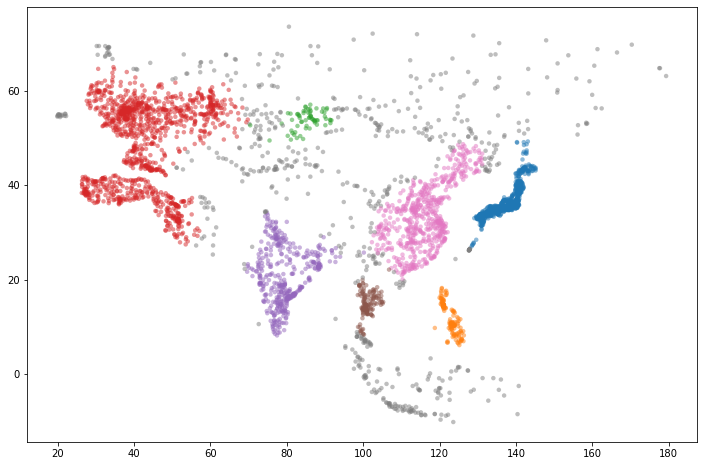

In [26]:
cluster_colors = ['C' + str(x) if x >= 0 else 'C7' for x in clusterer.labels_]
plt.scatter(X[:,0], X[:,1], c=cluster_colors, s=20, alpha=.5, linewidths=0);

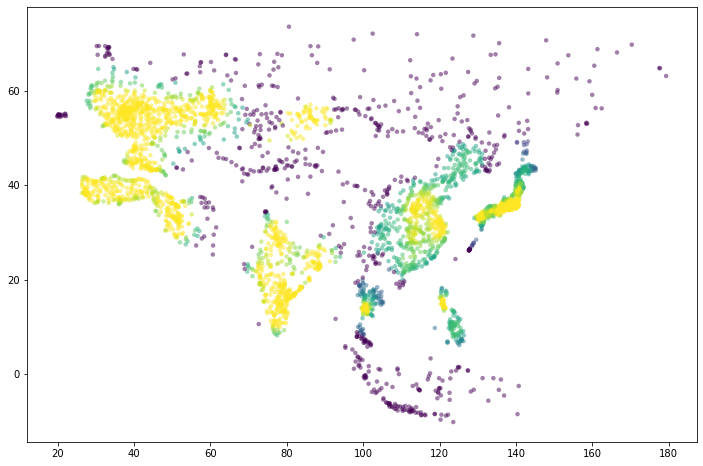

In [27]:
plt.scatter(X[:,0], X[:,1], c=clusterer.probabilities_, s=20, alpha=.5, linewidths=0);

In [28]:
# there is an easier way to make a table
pd.DataFrame([['k-means', 'Agglomerative'], ['DBSCAN', 'HDBSCAN']],
             columns=['Flat', 'Hierarchical'],
             index=['Centroid / Parametric', 'Density / Non-parametric']
            )

,Flat,Hierarchical
Centroid / Parametric,k-means,Agglomerative
Density / Non-parametric,DBSCAN,HDBSCAN
